#計算機程式設計二
#第十五週上課內容
## More on Problem Solving Using C++

三個傳教士和三個食人族要划船過河。
小船一次最多只能坐兩個人。
在岸上時，食人族的人數不能超過傳教士人數。
請問該如何將所有人平安運送到對岸？

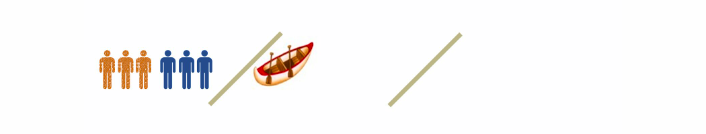

In [ ]:
%%writefile crossing.cpp
#include <algorithm>
#include <iostream>
#include <iterator>
#include <list>
#include <set>
#include <vector>
using namespace std;

class Crossing {
  public:
  using State=vector<int>;
  using Path=list<State>;

  Crossing(vector<int> mcs)
  {
    state = mcs;
    state.push_back(0);
    state.push_back(0);
    state.push_back(1);
    Path path;
    path.push_back(state);
    paths.insert(path);
  }

  State go(State s, int m, int c) {
    s[0] = s[0] - s[4]*m;
    s[1] = s[1] - s[4]*c;
    s[2] = s[2] + s[4]*m;
    s[3] = s[3] + s[4]*c;
    s[4] = -s[4];
    return s;
  }

  bool valid(State s) {
    if (s[0] != 0 && s[0] < s[1]) return false;
    if (s[2] != 0 && s[2] < s[3]) return false;
    if (s[0] < 0 || s[1] < 0 || s[2] < 0 || s[3] < 0) return false;
    return true;
  }

  set<State> extend(State s) {
    set<State> new_states;
    for (int m=0; m<=2; m++) {
      for (int c=0; c<=2; c++) {
        if (m+c>=1 && m+c<=2) {
            State ns = go(s, m, c);
            if (valid(ns))
              new_states.insert(ns);
        }
      }
    }
    return new_states;
  }

  bool is_solution(State s) {
    return s[0]==0 && s[1]==0 && s[4]==-1;
  }

  void solve(int steps) {

      while (steps > 0) {
        set<Path> new_paths;
        for (auto& p : paths) {
          set<State> new_states = extend(p.back());
          for (auto& s : new_states) {
            if (is_solution(s)) {
              Path np = p;
              np.push_back(s);
              solutions.insert(np);
            }
            if (explored.find(s) == explored.end()) {
              Path np = p;
              np.push_back(s);
              new_paths.insert(np);
              explored.insert(s);
            }
          }
        }
        paths = new_paths;
        steps--;
      }
  }

  void show_solutions() {
    for (auto& p: solutions) {
      for (auto& s : p) {
        show_state(s);
        cout << "->" ;
      }
      cout << "\n";
    }
  }

  void show_state(State s) {
    for (auto& e : s) {
      cout << e << ",";
    }
    cout << "\n";
  }

  private:
  State state;
  set<Path> solutions;
  set<Path> paths;
  set<State> explored;
};

int main()
{
  Crossing problem({3, 3});
  problem.solve(16);
  problem.show_solutions();
}


Overwriting crossing.cpp


In [ ]:
%%shell
g++ crossing.cpp -o crossing -std=c++1z
./crossing



3,3,0,0,1,
->2,2,1,1,-1,
->3,2,0,1,1,
->3,0,0,3,-1,
->3,1,0,2,1,
->1,1,2,2,-1,
->2,2,1,1,1,
->0,2,3,1,-1,
->0,3,3,0,1,
->0,1,3,2,-1,
->0,2,3,1,1,
->0,0,3,3,-1,
->
3,3,0,0,1,
->2,2,1,1,-1,
->3,2,0,1,1,
->3,0,0,3,-1,
->3,1,0,2,1,
->1,1,2,2,-1,
->2,2,1,1,1,
->0,2,3,1,-1,
->0,3,3,0,1,
->0,1,3,2,-1,
->0,2,3,1,1,
->0,0,3,3,-1,
->0,1,3,2,1,
->0,0,3,3,-1,
->
3,3,0,0,1,
->2,2,1,1,-1,
->3,2,0,1,1,
->3,0,0,3,-1,
->3,1,0,2,1,
->1,1,2,2,-1,
->2,2,1,1,1,
->0,2,3,1,-1,
->0,3,3,0,1,
->0,1,3,2,-1,
->1,1,2,2,1,
->0,0,3,3,-1,
->


In [ ]:
%%writefile missionary.cpp
#include <algorithm>
#include <iostream>
#include <iterator>
#include <list>
#include <set>
#include <sstream>
#include <string>
#include <vector>
using namespace std;
// A state contains five components:
// The first two components denote the current numbers of
// missionaries and cannibals at the left bank of the river.
// The third and fourth components denote the current numbers
// of missionaries and cannibals at the right bank.
// The fifth component denotes the location of the boat:
// 1 means "left bank" and -1 means "right bank".
using State = vector<int>;
class Crossing {
private:
  vector<int> _npeople; // how many missionaries and cannibals
                        // we use vector<int> as a tuple (int, int)
                        // the first integer indicate the number of missionaries
                        // the second integer indicates the number of cannibals
  set<list<State>> _paths; // trial paths in progress
  set<State> _explored;    // explored states
  set<list<State>> _solutions;

public:
  // specify the numbers of missionaries and cannibals
  Crossing(vector<int> np) : _npeople{np} {}
  // we may use s[4] to indicate the direction
  State Go(State s, int missionary, int cannibal) {
    s[0] = s[0] - s[4] * missionary;
    s[1] = s[1] - s[4] * cannibal;
    s[2] = s[2] + s[4] * missionary;
    s[3] = s[3] + s[4] * cannibal;
    s[4] = -s[4];
    return s;
  }

  // check the validity of a state
  bool valid(State s) {
    if (s[0] < 0 || s[1] < 0 || s[2] < 0 || s[3] < 0)
      return false;
    // cannibals must not outnumber missionaries
    if (s[0] < s[1] && s[0] != 0)
      return false;
    if (s[2] < s[3] && s[2] != 0)
      return false;

    return true;
  }

  set<State> extend(State s) {
    set<State> nextStates;

    for (int m = 0; m <= 2; m++) {
      for (int c = 0; c <= 2; c++) {
        // a boat can take one or two people
        if (m + c >= 1 && m + c <= 2) {
          State ss = Go(s, m, c);
          if (valid(ss))
            nextStates.insert(ss);
        }
      }
    }
    return nextStates;
  }

  // check if all people are at the right bank
  bool found(State s) {
    // s[4]==-1 means the boat is at the right bank
    if (s[0] == 0 && s[1] == 0 && s[4] == -1)
      return true;
    else
      return false;
  }

  void solve(int steps) {
    list<State> initialPath;

    State ss{_npeople}; // numbers of people at the left
    ss.push_back(0);    // no missionary at the right bank
    ss.push_back(0);    // no cannibals at the right bank
    ss.push_back(1);    // 1 means the boat at the left bank

    initialPath.push_back(ss);  // create the initial path
    _paths.insert(initialPath); // add the initial path into the path set _paths

    // same strategy as in the water jugs problem
    while (steps > 0) {
      set<list<State>> newPaths;

      for (auto p : _paths) {
        auto nextStates = extend(p.back());
        _explored.insert(p.back());
        for (auto s : nextStates) {
          if (found(s)) {
            auto np = p;
            np.push_back(s);
            _solutions.insert(np);
          } else {
            auto search = _explored.find(s);
            if (search == _explored.cend()) {
              auto np = p;
              np.push_back(s);
              newPaths.insert(np);
            }
          }
        }
      }

      _paths = newPaths;

      --steps;
    }
  }
  void show_solutions() {
    for (auto path : _solutions) {
      for (auto s : path) {
        if (!s.empty()) {
          cout << "(" << s[0] << ", " << s[1] << ")";
          cout << "(" << s[2] << ", " << s[3] << ")";
          if (s[4] == 1)
            cout << " left\n";
          else
            cout << " right\n";
        }
      }
      cout << "done" << endl;
    }
  }
};

int main() {
  vector<int> people = {3, 3};
  Crossing p(people);
  p.solve(25);
  p.show_solutions();
}


Overwriting missionary.cpp


In [ ]:
%%shell
g++ missionary.cpp -o missionary -std=c++1z
./missionary

(3, 3)(0, 0) left
(2, 2)(1, 1) right
(3, 2)(0, 1) left
(3, 0)(0, 3) right
(3, 1)(0, 2) left
(1, 1)(2, 2) right
(2, 2)(1, 1) left
(0, 2)(3, 1) right
(0, 3)(3, 0) left
(0, 1)(3, 2) right
(0, 2)(3, 1) left
(0, 0)(3, 3) right
done
(3, 3)(0, 0) left
(2, 2)(1, 1) right
(3, 2)(0, 1) left
(3, 0)(0, 3) right
(3, 1)(0, 2) left
(1, 1)(2, 2) right
(2, 2)(1, 1) left
(0, 2)(3, 1) right
(0, 3)(3, 0) left
(0, 1)(3, 2) right
(1, 1)(2, 2) left
(0, 0)(3, 3) right
done
(3, 3)(0, 0) left
(3, 1)(0, 2) right
(3, 2)(0, 1) left
(3, 0)(0, 3) right
(3, 1)(0, 2) left
(1, 1)(2, 2) right
(2, 2)(1, 1) left
(0, 2)(3, 1) right
(0, 3)(3, 0) left
(0, 1)(3, 2) right
(0, 2)(3, 1) left
(0, 0)(3, 3) right
done
(3, 3)(0, 0) left
(3, 1)(0, 2) right
(3, 2)(0, 1) left
(3, 0)(0, 3) right
(3, 1)(0, 2) left
(1, 1)(2, 2) right
(2, 2)(1, 1) left
(0, 2)(3, 1) right
(0, 3)(3, 0) left
(0, 1)(3, 2) right
(1, 1)(2, 2) left
(0, 0)(3, 3) right
done


四個人要過橋，天色很暗，走的時候必須拿火把照路才不會跌到橋下。橋很窄、火把亮度有限，所以同時最多只能兩個人一起走。四個人的走路速度不同，過橋所需的時間分別是 1, 2, 5, 10 分鐘，當兩個人一起走的時候，過橋時間必須遷就走得慢的那個人。請問最快要花多少時間可以讓四個人都到橋的另一邊？

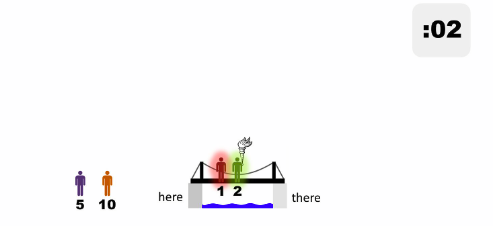

In [ ]:
%%writefile torch.cpp
#include <iostream>
#include <vector>
#include <algorithm>
#include <map>
#include <set>
#include <queue>
#include <iterator>
using namespace std;
class Torch
{
private:
    struct State {
        vector<int> here;
        vector<int> there;
        int direction;
        State() { }
        State(vector<int> ini): here(ini.size()), there(ini.size()), direction {1} {
            for(auto& i : here) // here = {1, 1, 1, 1} there = {0, 0, 0, 0}
            {
                i = 1;
            }
        }
        State(const State& s): here{s.here}, there{s.there}, direction{s.direction} { }
        State& operator=(const State & s)
        {
            State localstate{s};
            swap(here, localstate.here);
            swap(there, localstate.there);
            direction = localstate.direction;
            return *this;
        }

        bool operator<(const State & s) const
        {
            return (here < s.here) || ((here == s.here) && (there < s.there))
            || ((here == s.here) && (there == s.there) && direction < s.direction);
        }

        void show()
        {
            for (const auto& t : here) {
                cout << t << " ";
            }
            cout << "| ";
            for (const auto& t : there) {
                cout << t << " ";
            }
            if (direction == 1)
                cout << " Left\n";
            else
                cout << " Right\n";
        }
    }; // end of struct State

    using Choice = pair<int, State>;

    vector<int> walking_time;
    map<State, int> best_cost;
    map<State, State> prev_state;


    set<Choice> extend(Choice ch)
    {
            set<Choice> nextChoices;
            int dir = ch.second.direction;
            for (unsigned int i=0; i<ch.second.here.size(); ++i) {
                if (ch.second.here[i]==dir) {
                    // alone
                    State ns(ch.second);
                    ns.here[i] = 1-dir; // 0 -> 1 or 1 -> 0
                    ns.there[i] = dir;
                    ns.direction = 1-dir;
                    Choice nc = make_pair(ch.first-walking_time[i], ns);
                    nextChoices.insert(nc);
                    // with company
                    for (unsigned int j=i+1; j<ch.second.here.size(); ++j) {
                        if (ns.here[j]==dir) {
                            State ns2(ns);
                            ns2.here[j] = 1-dir;
                            ns2.there[j] = dir;
                            int total_cost =
                                (walking_time[i]>walking_time[j])
                                ? walking_time[i] : walking_time[j];
                            Choice nc2 = make_pair(ch.first-total_cost, ns2);
                            nextChoices.insert(nc2);
                        }
                    }
                }
            }

        return nextChoices;
    }

    bool found(State s)
    {
        if (s.direction==1) return false;
        return all_of(s.here.begin(), s.here.end(), [](int x){return x==0;});
    }

    void trace_back(State s)
    {
        State ini(walking_time); // here={1, 1, 1, 1}, there={0, 0, 0, 0}
        while (s<ini || ini<s) {
            s.show();
            State ns = prev_state[s];
            s = ns;
        }
        ini.show();
    }

public:

    Torch(vector<int> wt): walking_time {wt} { }
    void solve()
    {
        State initialState(walking_time);
        Choice item = make_pair(0, initialState);
        prev_state[initialState] = initialState;

        priority_queue<Choice> pq;
        pq.push(item);

        while (!pq.empty()) {
            Choice currentChoice = pq.top();
            pq.pop();

            if (found(currentChoice.second)) {
                cout << "Answer: ";
                cout << -currentChoice.first << "\n";
                cout << "Tracing back:\n";
                trace_back(currentChoice.second);
                break;
            }

            set<Choice> chs = extend(currentChoice);
            for (auto c : chs) {
                int newCost = c.first;
                State newState = c.second;
                auto search = best_cost.find(newState);
                if (search == best_cost.cend() || newCost > best_cost[newState]) {
                    best_cost[newState] = newCost;
                    prev_state[newState] = currentChoice.second;
                    Choice newItem = make_pair(newCost, newState);
                    pq.push(newItem);
                }
            }

        }

    }
};

int main()
{
    vector<int> walking_time = {1, 2, 5, 10};
    Torch problem(walking_time);
    problem.solve();
}


Writing torch.cpp


In [ ]:
%%shell
g++ torch.cpp -o torch -std=c++1z
./torch

Answer: 17
Tracing back:
0 0 0 0 | 1 1 1 1  Right
1 1 0 0 | 0 0 1 1  Left
1 0 0 0 | 0 1 1 1  Right
1 0 1 1 | 0 1 0 0  Left
0 0 1 1 | 1 1 0 0  Right
1 1 1 1 | 0 0 0 0  Left
